In [18]:
from Gian_experimental.NSGAIICustom.CustomOperators import NCSamplerFromPRef, NCMutationCounterproductive, \
    NCCrossoverTransition
from Gian_experimental.NSGAIICustom.NSGAIICustom import EvaluatedNCSolution, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple
from scipy.stats import ks_2samp, wasserstein_distance
from Gian_experimental.NSGAIICustom.testing_in_vitro.testing_operators_in_vitro import make_metrics_cached

#dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"
# dir_250 = r"/Users/gian/PycharmProjects/PSSearch/data/retail_forecasting/250"

data_path = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"
import heapq
import itertools
import json
import random
from typing import Iterable, Optional, Iterator

import numpy as np

import utils
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import SPRef, OptimisedSPref
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities, get_transition_matrix
from PolishSystem.read_data import get_pRef_from_vectors
import os
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import get_transition_matrix
from typing import Iterable
import heapq

def in_path(path):
    return os.path.join(data_path, path)

n = 250

train_pRef = get_pRef_from_vectors(name_of_vectors_file=in_path(f"train_many_hot_vectors_{n}_random.csv"),
                                   name_of_fitness_file=in_path(f"train_fitness_{n}_random.csv"),
                                   column_in_fitness_file=2)
test_pRef =  get_pRef_from_vectors(name_of_vectors_file=in_path(f"test_many_hot_vectors_{n}_random.csv"),
                                   name_of_fitness_file=in_path(f"test_fitness_{n}_random.csv"),
                                   column_in_fitness_file=2)

train_SPRef = OptimisedSPref.from_pRef(train_pRef)
test_SPRef = OptimisedSPref.from_pRef(test_pRef)

cluster_info_file_name = in_path(f"cluster_info_{n}_random.pkl")
similarities = gian_get_similarities(cluster_info_file_name)



def keep_with_best_first_metric(population: Iterable[EvaluatedNCSolution], quantity_required: int):
    return heapq.nsmallest(iterable=population, key=lambda x: x.fitnesses[0], n=quantity_required)

transition_matrix = get_transition_matrix(similarities)
custom_sampling = NCSamplerFromPRef.from_PRef(train_pRef)
custom_mutation = NCMutationCounterproductive(transition_matrix)
custom_crossover = NCCrossoverTransition(transition_matrix)

def atomicity(ps):
    if len(ps) < 2:
        return -1000
    else:
        linkages = [similarities[a, b] for a, b in itertools.combinations(ps, r=2)]
        return np.average(linkages)

traditional_sampling = NCSamplerSimple.with_average_quantity(3, genome_size=n)
traditional_mutation = NCMutationSimple(n)
traditional_crossover = NCCrossoverSimple(swap_probability=1 / n)



print(f"The range of values in the similarities is {np.min(similarities), np.max(similarities)}")


The range of values in the similarities is (-19.029871, 80.21128)


In [44]:
from Gian_experimental.NSGAIICustom.evolving_genome_threshold import NCSolutionWithGT, SimpleSampleGT, SimpleMutateGT, \
    SimpleCrossoverGT, SampleWithFixedGT, MutateExceptGT
from scipy.stats import mannwhitneyu
from Gian_experimental.NSGAIICustom.NSGAIICustom import NCSolution, NSGAIICustom



def get_metrics(ps: NCSolutionWithGT) -> tuple[float]:
    matching, non_matching = train_SPRef.partition(ps, threshold=ps.genome_threshold)
    if len(matching) < 1000: # a constraint
        return 1000, 1000, 1000, 1000

    # median_diff = np.median(matching) - np.median(non_matching)
    atomicity_score = atomicity(ps)
    
    return (len(ps), -len(matching), -np.average(matching), -atomicity_score)


mutation_with_gt = SimpleMutateGT(traditional_mutation)
mutation_with_gt.probability_of_change = 0.1

algorithm = NSGAIICustom(sampling=SimpleSampleGT(traditional_sampling),
                         mutation=SimpleMutateGT(traditional_mutation),
                         crossover=SimpleCrossoverGT(traditional_crossover),
                         probability_of_crossover=0.5,
                         eval_budget=10000,
                         pop_size=100,
                         tournament_size=3,
                         mo_fitness_function=make_metrics_cached(get_metrics),
                         unique=True,
                         verbose=True,
                         culler=keep_with_best_first_metric
                         )

In [36]:
results  = algorithm.run()

NSGAIICustom -> Beginning of NC process
NSGAIICustom -> Used evals: 210
NSGAIICustom -> Used evals: 316
NSGAIICustom -> Used evals: 421
NSGAIICustom -> Used evals: 532
NSGAIICustom -> Used evals: 637
NSGAIICustom -> Used evals: 748
NSGAIICustom -> Used evals: 861
NSGAIICustom -> Used evals: 971
NSGAIICustom -> Used evals: 1083
NSGAIICustom -> Used evals: 1191
NSGAIICustom -> Used evals: 1298
NSGAIICustom -> Used evals: 1401
NSGAIICustom -> Used evals: 1510
NSGAIICustom -> Used evals: 1616
NSGAIICustom -> Used evals: 1725
NSGAIICustom -> Used evals: 1828
NSGAIICustom -> Used evals: 1937
NSGAIICustom -> Used evals: 2042
NSGAIICustom -> Used evals: 2146
NSGAIICustom -> Used evals: 2253
NSGAIICustom -> Used evals: 2362
NSGAIICustom -> Used evals: 2469
NSGAIICustom -> Used evals: 2573
NSGAIICustom -> Used evals: 2683
NSGAIICustom -> Used evals: 2793
NSGAIICustom -> Used evals: 2908
NSGAIICustom -> Used evals: 3014
NSGAIICustom -> Used evals: 3123
NSGAIICustom -> Used evals: 3231
NSGAIICusto

There are 83 results
(2, -3882, -1.3440709114074707, -1.4196144) 2
(2, -8034, -1.05183744430542, -2.6819165) 2
(8, -13307, -0.9307539463043213, -1.1482031) 8
(2, -7297, -1.1204991340637207, -1.6338487) 2
(2, -10609, -1.099567174911499, -1.0632222) 2
(2, -5572, -1.2885394096374512, -0.68769723) 2
(3, -6725, -1.1264371871948242, -4.700154) 3
(3, -12811, -0.9845826625823975, 0.19048698) 3
(2, -7386, -0.9417891502380371, -2.8231678) 2
(3, -3673, -1.276076316833496, -2.9540155) 3
(3, -2757, -1.8871471881866455, -0.78428125) 3
(3, -1091, -2.8920462131500244, -1.6009423) 3
(4, -12921, -1.0327813625335693, -1.6999931) 4
(3, -10846, -1.1021537780761719, -1.4628161) 3
(3, -11134, -0.9504332542419434, -1.2627195) 3
(2, -1771, -1.7238140106201172, 0.46988258) 2
(2, -1462, -1.4115753173828125, -8.053384) 2
(2, -11603, -0.8461687564849854, -1.0848411) 2
(2, -7868, -1.1186466217041016, -1.2068508) 2
(3, -14647, -0.9747803211212158, -0.29388008) 3
(3, -3691, -1.3139607906341553, -1.5093018) 3
(9, -413

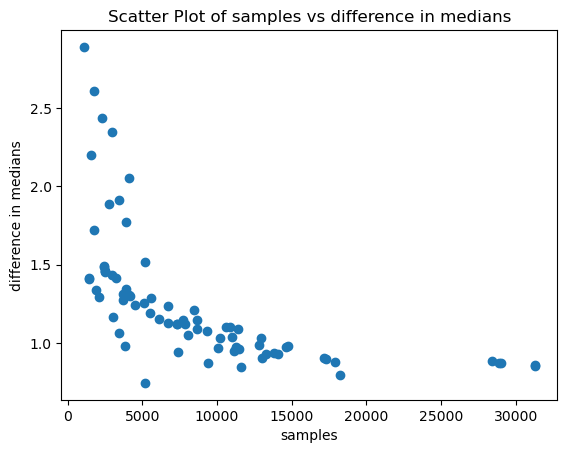

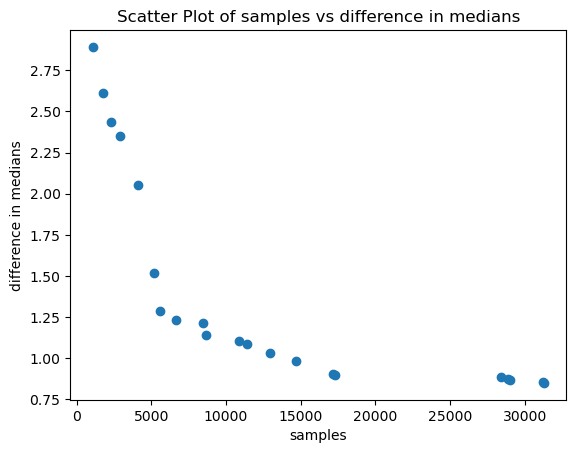

In [43]:
from collections import defaultdict

print(f"There are {len(results)} results")

for result in results:
    print(result.fitnesses, len(result.solution))

gt_counts = defaultdict(int)
for result in results:
    gt_counts[result.solution.genome_threshold] +=1 
print(gt_counts)    

def show_scatterplot_for_fitnesses(individuals, col_x, col_y):
    vals_a = [-ps.fitnesses[col_x] for ps in individuals if len(ps.solution) > 1]
    vals_b = [-ps.fitnesses[col_y] for ps in individuals if len(ps.solution) > 1]
    
    utils.simple_scatterplot(x_label="samples", y_label="difference in medians", xs=vals_a, ys=vals_b)



## only plotting the pareto front
col_x = 1
col_y = 2
show_scatterplot_for_fitnesses(results, col_x, col_y)
results_with_only_those = [EvaluatedNCSolution(solution=i.solution, fitnesses = (i.fitnesses[col_x], i.fitnesses[col_y])) for i in results]
pareto_fronts = algorithm.get_pareto_fronts(results_with_only_those)
best_front = pareto_fronts[0]

show_scatterplot_for_fitnesses(best_front, 0, 1)



In [5]:


from matplotlib import pyplot as plt
from Gian_experimental.plotting_utils import display_side_by_side

def compare_histograms(
    data1,
    data2,
    bins=30,
    log_x=False,
    log_y=False,
    labels=("Data 1", "Data 2"),
    title="Histogram Comparison",
    figsize=(6, 4),
    ax=None,
    y_axis_frequency="absolute",  # "absolute" or "relative"
):
    """
    Creates a histogram comparison plot of two datasets on a given Axes or a new figure.

    Parameters:
        ...
        y_axis_frequency (str): "absolute" for counts, "relative" for percentages (0–100%).

    Returns:
        matplotlib.figure.Figure or None
    """
    data1 = np.array(data1)
    data2 = np.array(data2)

    if log_x:
        data1 = data1[data1 > 0]
        data2 = data2[data2 > 0]
        combined = np.concatenate([data1, data2])
        min_val = combined.min()
        max_val = combined.max()
        bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None

    density = y_axis_frequency == "relative"

    ax.hist(data1, bins=bins, alpha=0.5, label=labels[0], edgecolor='black', density=density)
    ax.hist(data2, bins=bins, alpha=0.5, label=labels[1], edgecolor='black', density=density)

    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')

    ax.set_xlabel("Value")
    ax.set_ylabel("Percentage" if density else "Frequency")

    if density:
        # Convert y-axis to percentage
        ticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])

    ax.set_title(title)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    return fig

def display_side_by_side(histogram_args_list, figsize_per_plot=(5, 5)):
    """
    Displays multiple histograms side-by-side using `compare_histograms`.

    Parameters:
        histogram_args_list (list[dict]): Each dict contains args for `compare_histograms`.
        figsize_per_plot (tuple): Size per individual plot; used to scale total figure.
    """
    num = len(histogram_args_list)
    total_figsize = (figsize_per_plot[0] * num, figsize_per_plot[1])
    fig, axs = plt.subplots(1, num, figsize=total_figsize)

    if num == 1:
        axs = [axs]  # Ensure it's iterable

    for args, ax in zip(histogram_args_list, axs):
        compare_histograms(ax=ax, **args)

    plt.tight_layout()
    plt.show()


def get_textual_description_of_distribution(values):
    return (f"n = {len(values)},\n"
              f"average = {np.average(values):.2f}, median = {np.median(values):.2f}\n"
              f"min = {np.min(values):.2f}, max = {np.max(values):.2f},\n")

def make_ps_into_explanation(ps: NCSolutionWithGT, test_SPref: SPRef):
    print(f"If you match this list of {len(ps)}, with threshold {ps.genome_threshold}:")
    print(ps)
    

    match_fitnesses, match_non_fitnesses = test_SPref.partition(ps, ps.genome_threshold)
    
    if len(match_fitnesses) < 100 or len(match_non_fitnesses) < 100:
        print(f"There are not enough matches!!!  {len(match_fitnesses)}, {len(match_non_fitnesses)}")
        return
    distance = wasserstein_distance(match_fitnesses, match_non_fitnesses)
    
    print(f"The Wasserstein distance is {distance}")
    print("Distribution of match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_fitnesses)))
    print("Distribution of non match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_non_fitnesses)))
    
    display_side_by_side([
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Fitnesses of matches vs non-matches",
                "labels": ("Matches", "Non matches"),
                "y_axis_frequency": "relative"
            },
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Absolute view",
                "labels": ("Matches", "Non Matches"),
                "y_axis_frequency": "absolute"
            }
        ])

0 {217, 93}, gt=1
1 {237, 93, 135}, gt=2
2 {217, 154, 241, 103}, gt=1
3 {88, 79, 103}, gt=1
4 {121, 36, 75, 79, 16, 241, 211, 179, 217}, gt=2
5 {217, 188, 53}, gt=2
6 {88, 16, 93, 149}, gt=1
7 {88, 93}, gt=1
8 {217, 188, 197, 68}, gt=1
9 {188, 219, 212, 151}, gt=1
10 {88, 113, 217}, gt=1
11 {217, 188, 233}, gt=1
12 {36, 217, 75, 236, 237, 143, 16, 241, 244, 121}, gt=1
13 {246, 103}, gt=1
14 {152, 113, 212}, gt=1
15 {68, 196, 170, 110, 177, 216, 217, 188}, gt=1
16 {88, 248, 44, 93}, gt=2
17 {217, 169, 92, 93}, gt=2
18 {217, 188}, gt=1
19 {117, 184, 88, 28, 158}, gt=1
20 {97, 248, 88, 44, 93}, gt=2
21 are satisfactory out of 83
The metrics were (-1091, -2.8920462131500244)
If you match this list of 3, with threshold 2:
{237, 93, 135}, gt=2
The Wasserstein distance is 2.937907289249988
Distribution of match fitness
	n = 442,
	average = 10.51, median = 9.85
	min = 3.18, max = 38.68,
	
Distribution of non match fitness
	n = 15396,
	average = 7.58, median = 7.40
	min = 0.07, max = 26.30,
	


C:\Users\gac8\AppData\Local\Temp\ipykernel_10852\1072996255.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


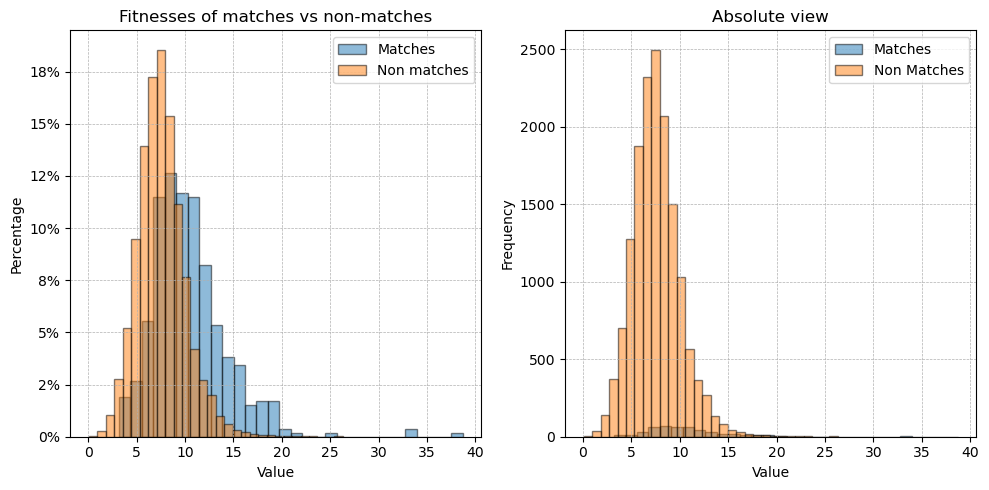

The metrics were (-1741, -2.612556219100952)
If you match this list of 4, with threshold 2:
{217, 169, 92, 93}, gt=2
The Wasserstein distance is 2.983385534081718
Distribution of match fitness
	n = 795,
	average = 10.49, median = 10.03
	min = 1.41, max = 38.68,
	
Distribution of non match fitness
	n = 15043,
	average = 7.51, median = 7.35
	min = 0.07, max = 25.69,
	


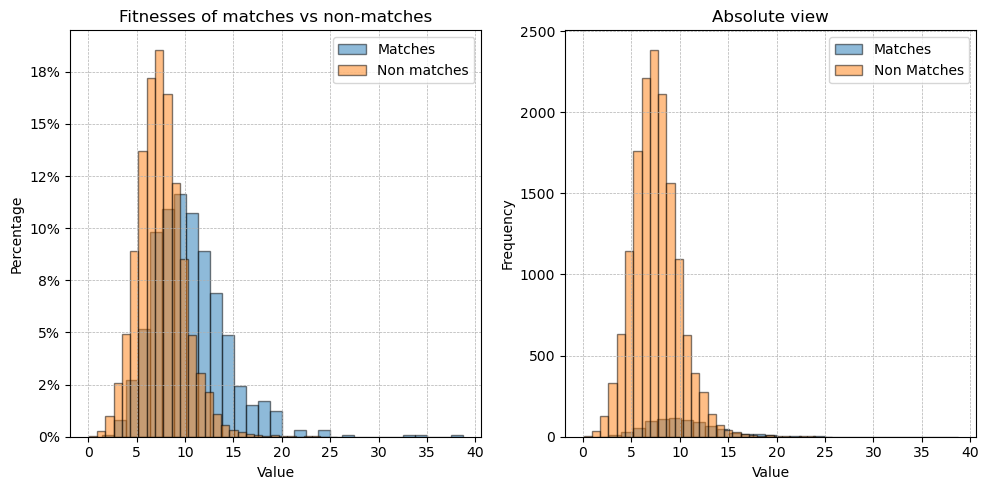

The metrics were (-2305, -2.438025951385498)
If you match this list of 4, with threshold 2:
{88, 248, 44, 93}, gt=2
The Wasserstein distance is 2.7589431525486727
Distribution of match fitness
	n = 1018,
	average = 10.24, median = 9.77
	min = 2.19, max = 38.68,
	
Distribution of non match fitness
	n = 14820,
	average = 7.48, median = 7.33
	min = 0.07, max = 25.69,
	


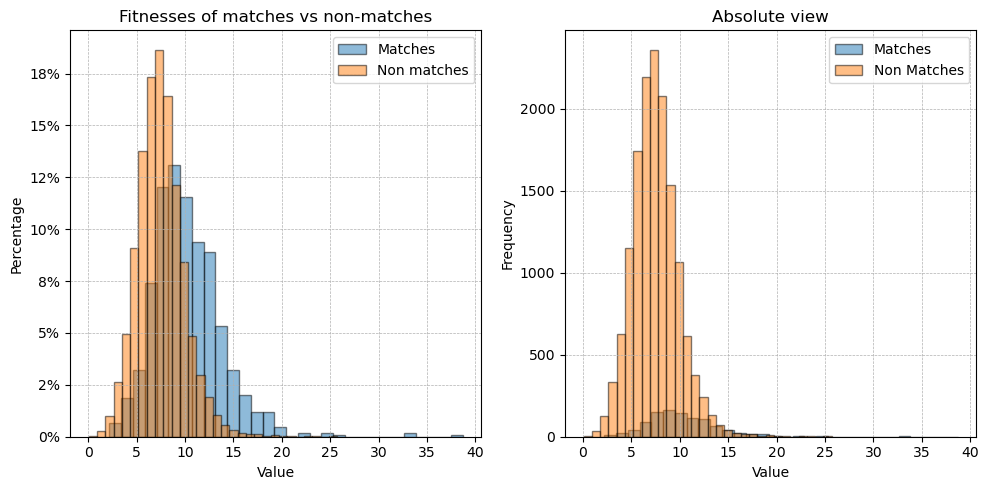

The metrics were (-2937, -2.3512635231018066)
If you match this list of 5, with threshold 2:
{97, 248, 88, 44, 93}, gt=2
The Wasserstein distance is 2.668532324978236
Distribution of match fitness
	n = 1267,
	average = 10.11, median = 9.74
	min = 2.02, max = 38.68,
	
Distribution of non match fitness
	n = 14571,
	average = 7.44, median = 7.31
	min = 0.07, max = 25.69,
	


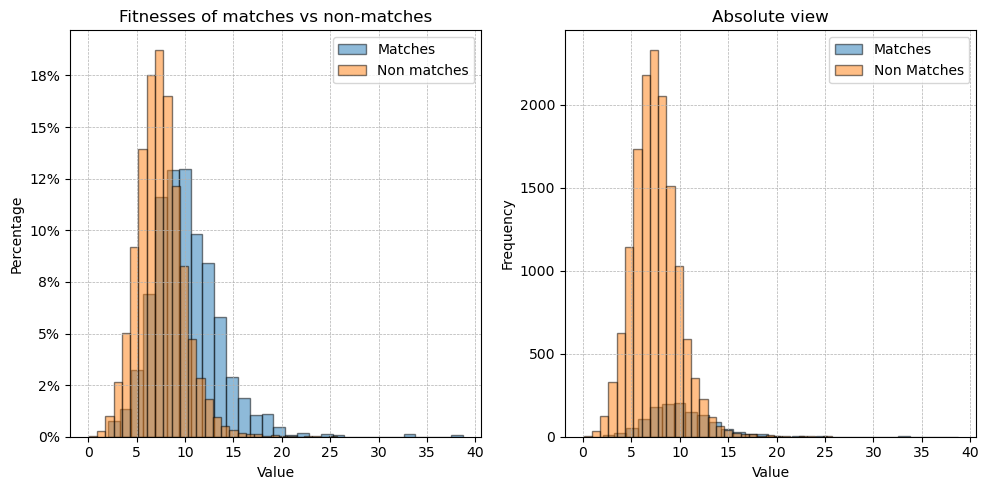

The metrics were (-4136, -2.051908493041992)
If you match this list of 9, with threshold 2:
{121, 36, 75, 79, 16, 241, 211, 179, 217}, gt=2
The Wasserstein distance is 2.42533979020755
Distribution of match fitness
	n = 1753,
	average = 9.81, median = 9.30
	min = 0.07, max = 38.68,
	
Distribution of non match fitness
	n = 14085,
	average = 7.39, median = 7.28
	min = 0.14, max = 24.74,
	


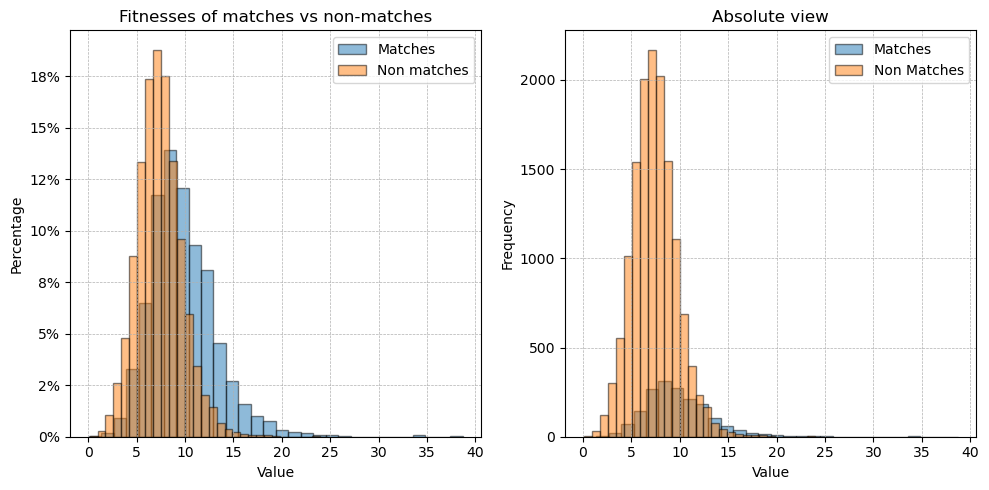

The metrics were (-5186, -1.5194587707519531)
If you match this list of 3, with threshold 2:
{217, 188, 53}, gt=2
The Wasserstein distance is 1.8314364970013233
Distribution of match fitness
	n = 2228,
	average = 9.23, median = 8.76
	min = 1.82, max = 38.68,
	
Distribution of non match fitness
	n = 13610,
	average = 7.40, median = 7.27
	min = 0.07, max = 26.30,
	


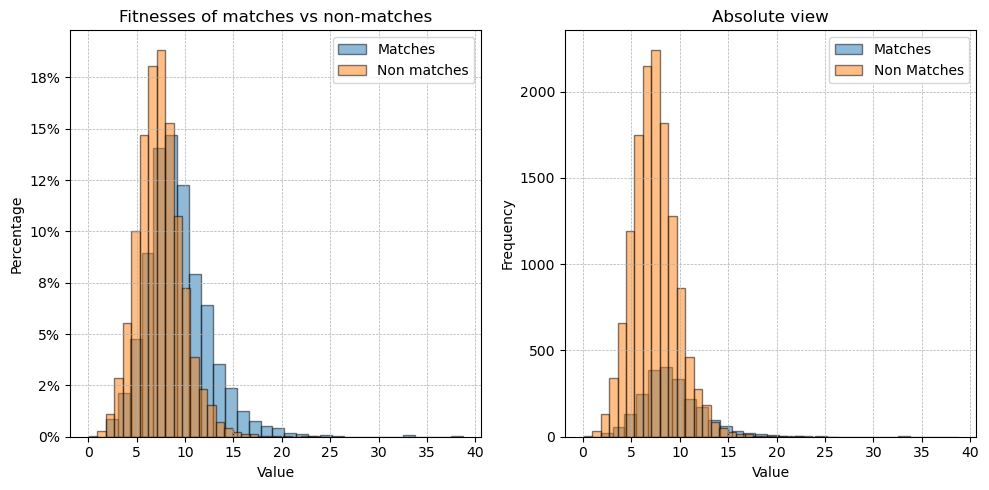

The metrics were (-5572, -1.2885394096374512)
If you match this list of 2, with threshold 1:
{217, 93}, gt=1
The Wasserstein distance is 1.6459717166242154
Distribution of match fitness
	n = 2351,
	average = 9.06, median = 8.54
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 13487,
	average = 7.41, median = 7.28
	min = 0.07, max = 24.74,
	


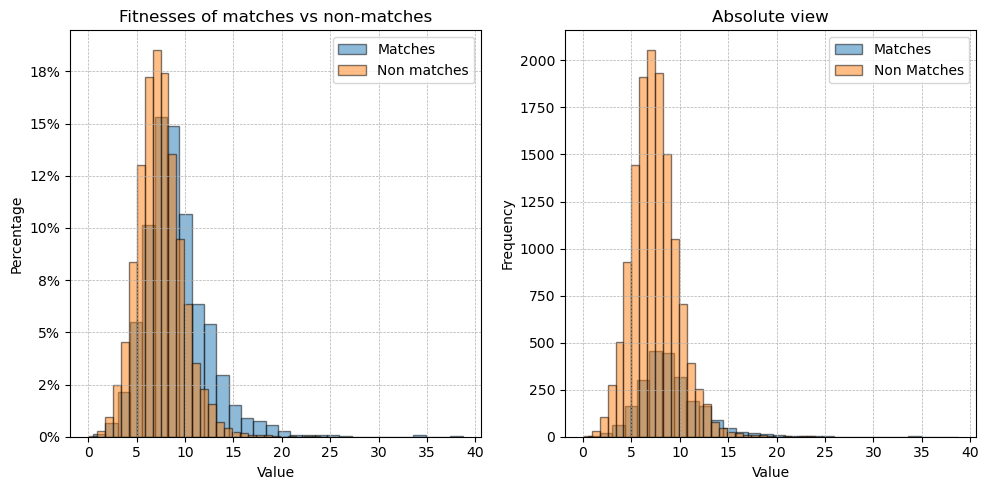

The metrics were (-6688, -1.234382152557373)
If you match this list of 2, with threshold 1:
{88, 93}, gt=1
The Wasserstein distance is 1.5170600967641548
Distribution of match fitness
	n = 2867,
	average = 8.90, median = 8.43
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 12971,
	average = 7.38, median = 7.26
	min = 0.07, max = 24.89,
	


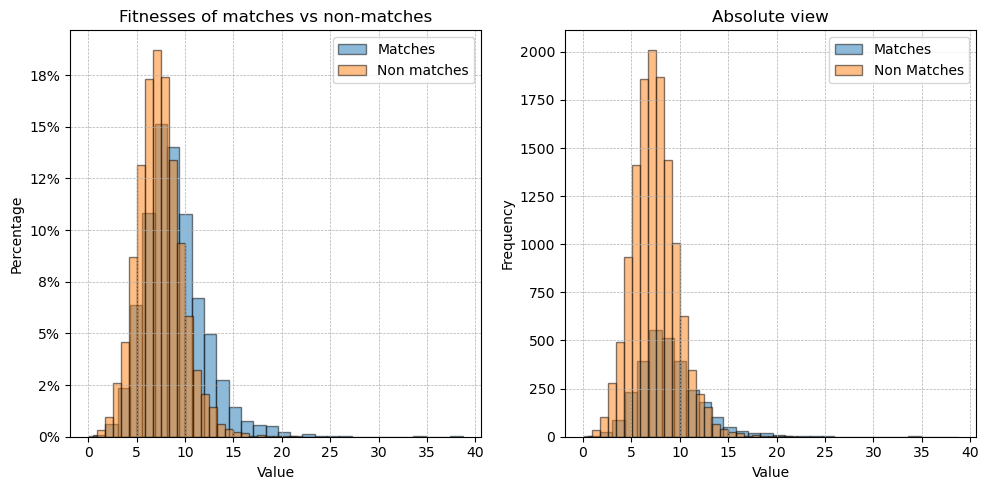

The metrics were (-8433, -1.2113287448883057)
If you match this list of 3, with threshold 1:
{88, 113, 217}, gt=1
The Wasserstein distance is 1.4902180939852268
Distribution of match fitness
	n = 3603,
	average = 8.81, median = 8.39
	min = 1.47, max = 38.68,
	
Distribution of non match fitness
	n = 12235,
	average = 7.32, median = 7.21
	min = 0.07, max = 23.30,
	


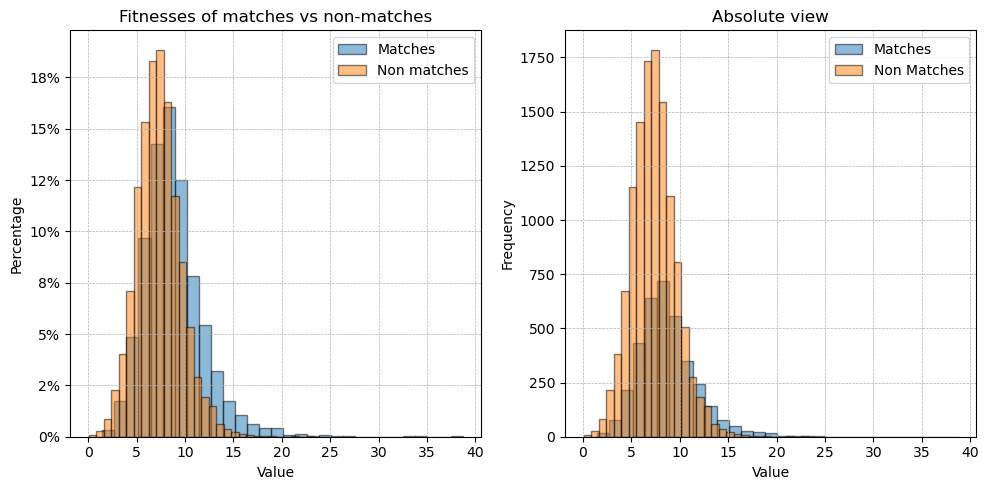

The metrics were (-8689, -1.1434526443481445)
If you match this list of 2, with threshold 1:
{246, 103}, gt=1
The Wasserstein distance is 1.406019614358867
Distribution of match fitness
	n = 3740,
	average = 8.73, median = 8.28
	min = 0.70, max = 38.68,
	
Distribution of non match fitness
	n = 12098,
	average = 7.33, median = 7.23
	min = 0.07, max = 24.74,
	


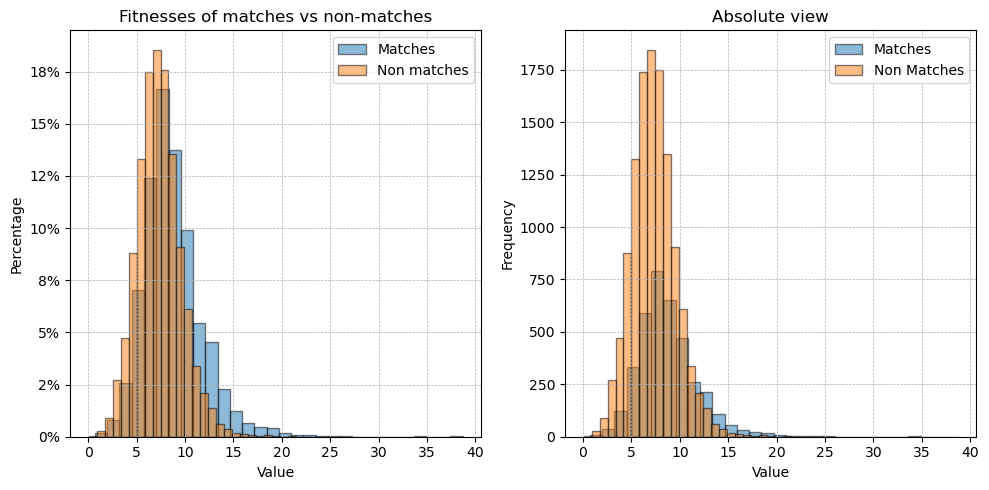

The metrics were (-10846, -1.1021537780761719)
If you match this list of 3, with threshold 1:
{88, 79, 103}, gt=1
The Wasserstein distance is 1.3098083273245944
Distribution of match fitness
	n = 4620,
	average = 8.59, median = 8.16
	min = 0.70, max = 38.68,
	
Distribution of non match fitness
	n = 11218,
	average = 7.28, median = 7.18
	min = 0.07, max = 23.30,
	


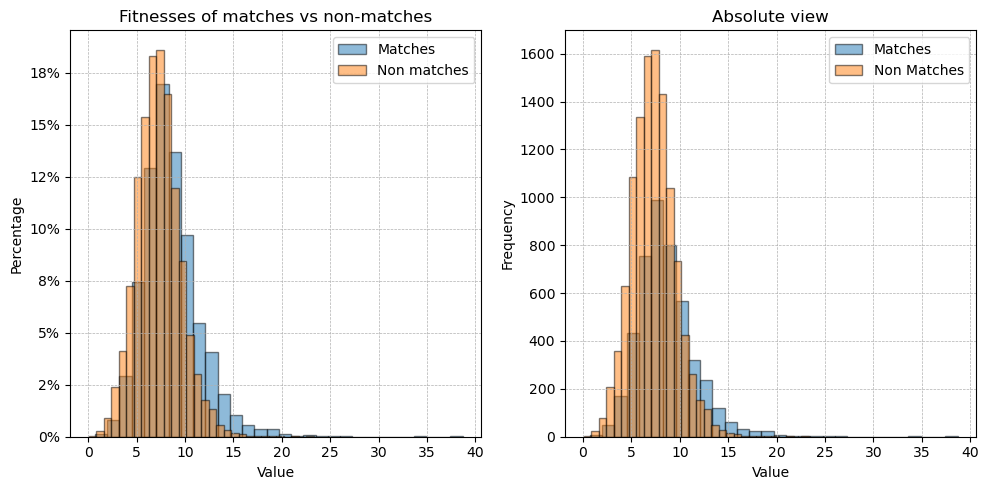

The metrics were (-11417, -1.0880088806152344)
If you match this list of 4, with threshold 1:
{88, 16, 93, 149}, gt=1
The Wasserstein distance is 1.3339705799421933
Distribution of match fitness
	n = 4993,
	average = 8.57, median = 8.20
	min = 0.07, max = 38.68,
	
Distribution of non match fitness
	n = 10845,
	average = 7.24, median = 7.14
	min = 0.14, max = 24.89,
	


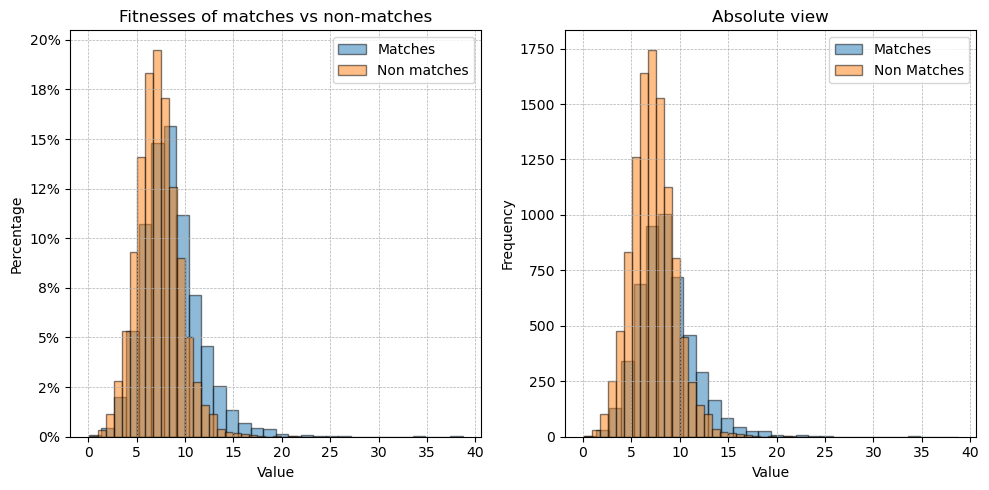

The metrics were (-12921, -1.0327813625335693)
If you match this list of 4, with threshold 1:
{217, 154, 241, 103}, gt=1
The Wasserstein distance is 1.3088515311223363
Distribution of match fitness
	n = 5519,
	average = 8.51, median = 8.14
	min = 0.70, max = 38.68,
	
Distribution of non match fitness
	n = 10319,
	average = 7.20, median = 7.12
	min = 0.07, max = 24.74,
	


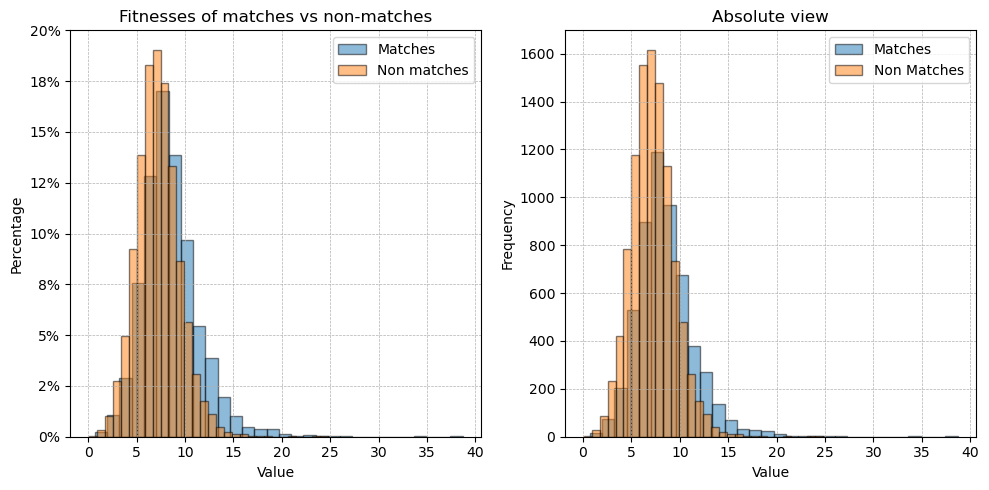

The metrics were (-14719, -0.9815080165863037)
If you match this list of 5, with threshold 1:
{117, 184, 88, 28, 158}, gt=1
The Wasserstein distance is 1.1980338320872321
Distribution of match fitness
	n = 6339,
	average = 8.38, median = 8.03
	min = 0.92, max = 38.68,
	
Distribution of non match fitness
	n = 9499,
	average = 7.18, median = 7.08
	min = 0.07, max = 23.30,
	


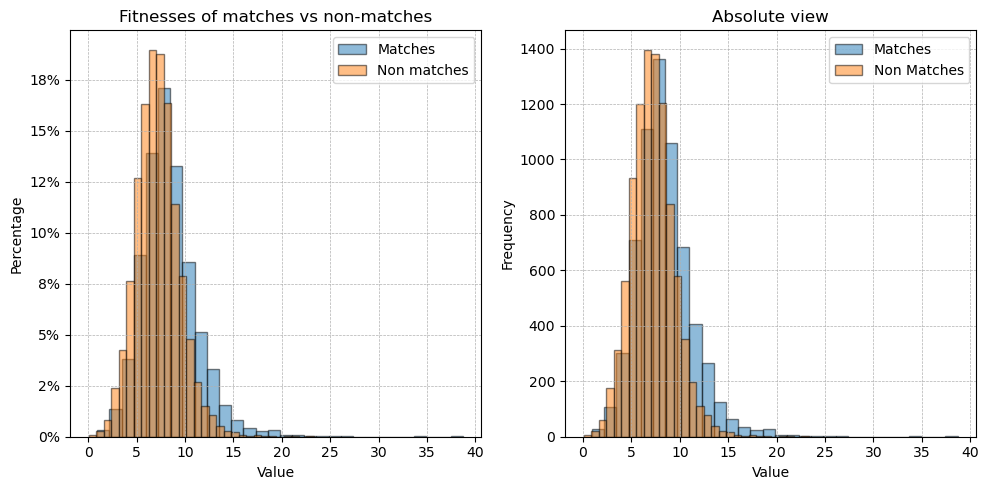

The metrics were (-17159, -0.9017837047576904)
If you match this list of 10, with threshold 1:
{36, 217, 75, 236, 237, 143, 16, 241, 244, 121}, gt=1
The Wasserstein distance is 1.1252702400375725
Distribution of match fitness
	n = 7418,
	average = 8.26, median = 7.93
	min = 0.07, max = 38.68,
	
Distribution of non match fitness
	n = 8420,
	average = 7.13, median = 7.06
	min = 0.14, max = 20.74,
	


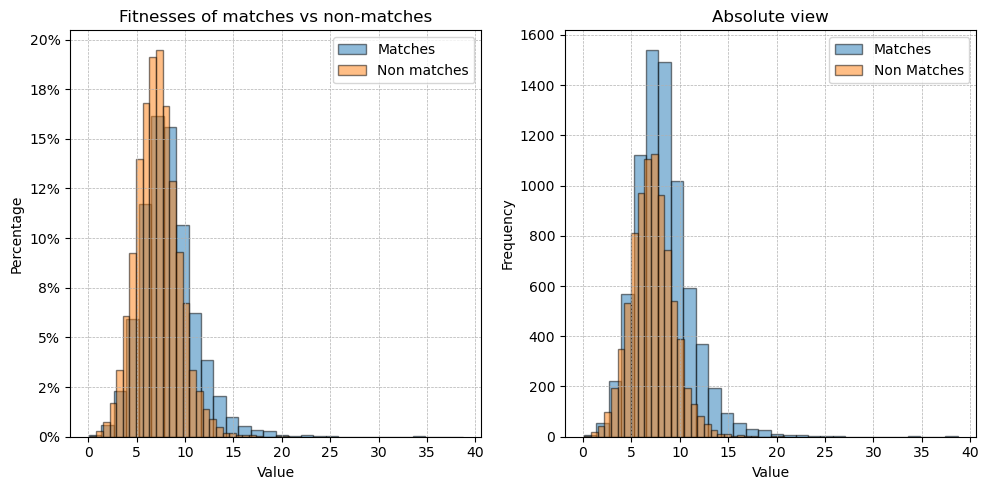

The metrics were (-17326, -0.8970413208007812)
If you match this list of 3, with threshold 1:
{152, 113, 212}, gt=1
The Wasserstein distance is 1.0363128545893296
Distribution of match fitness
	n = 7439,
	average = 8.21, median = 7.90
	min = 1.02, max = 38.68,
	
Distribution of non match fitness
	n = 8399,
	average = 7.17, median = 7.07
	min = 0.07, max = 25.69,
	


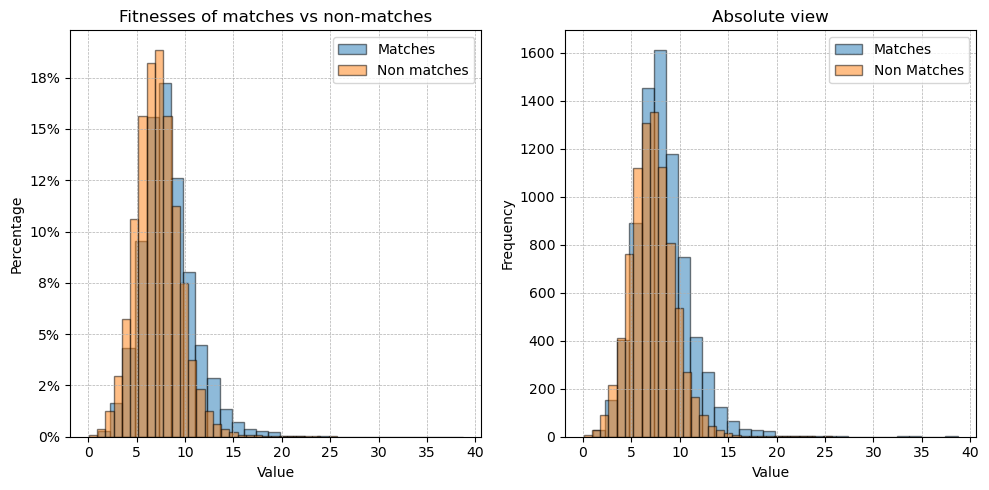

The metrics were (-28430, -0.8869059085845947)
If you match this list of 2, with threshold 1:
{217, 188}, gt=1
The Wasserstein distance is 1.0313967303326455
Distribution of match fitness
	n = 12326,
	average = 7.89, median = 7.63
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 3512,
	average = 6.85, median = 6.81
	min = 0.07, max = 24.74,
	


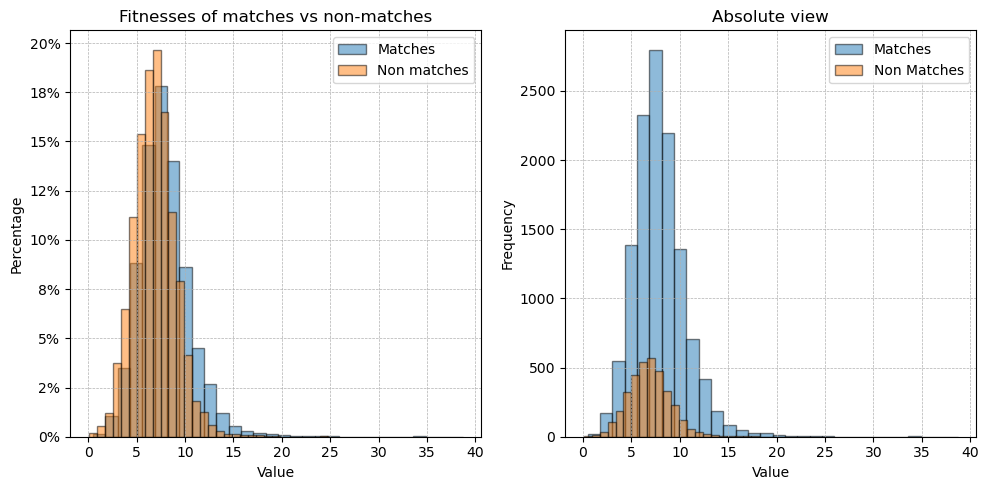

The metrics were (-28891, -0.8709254264831543)
If you match this list of 3, with threshold 1:
{217, 188, 233}, gt=1
The Wasserstein distance is 1.0049029867060115
Distribution of match fitness
	n = 12493,
	average = 7.87, median = 7.62
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 3345,
	average = 6.86, median = 6.82
	min = 0.07, max = 24.74,
	


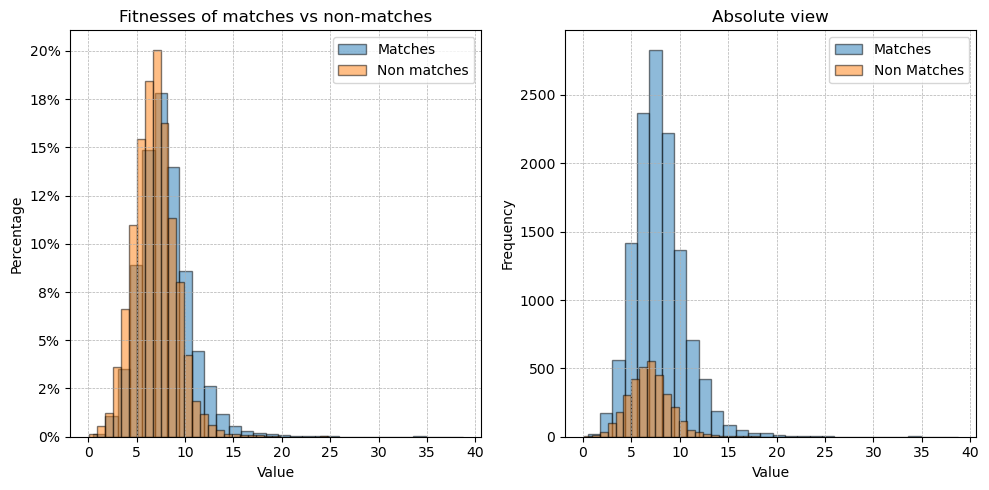

The metrics were (-29007, -0.8687071800231934)
If you match this list of 4, with threshold 1:
{217, 188, 197, 68}, gt=1
The Wasserstein distance is 1.0206904366514373
Distribution of match fitness
	n = 12568,
	average = 7.87, median = 7.61
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 3270,
	average = 6.85, median = 6.81
	min = 0.07, max = 24.74,
	


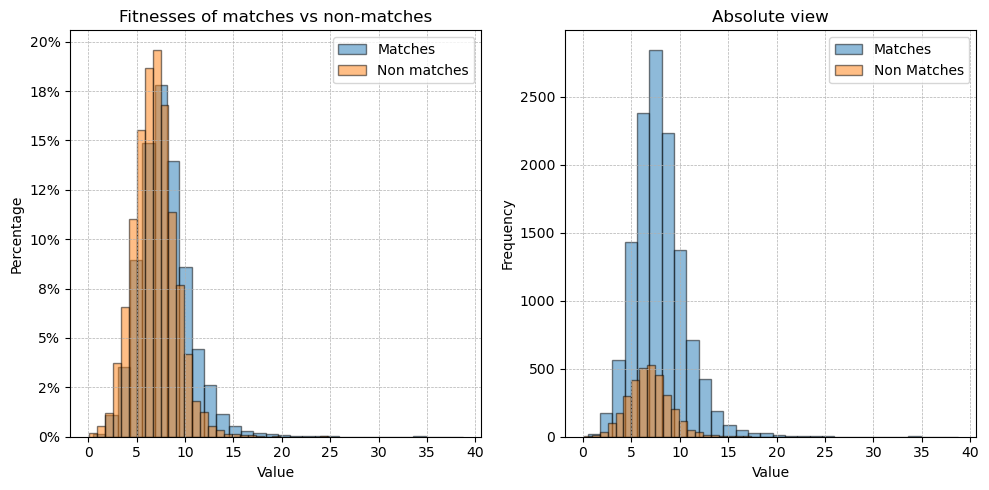

The metrics were (-31253, -0.8573660850524902)
If you match this list of 8, with threshold 1:
{68, 196, 170, 110, 177, 216, 217, 188}, gt=1
The Wasserstein distance is 0.9703541668786446
Distribution of match fitness
	n = 13492,
	average = 7.80, median = 7.56
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 2346,
	average = 6.83, median = 6.83
	min = 0.07, max = 24.74,
	


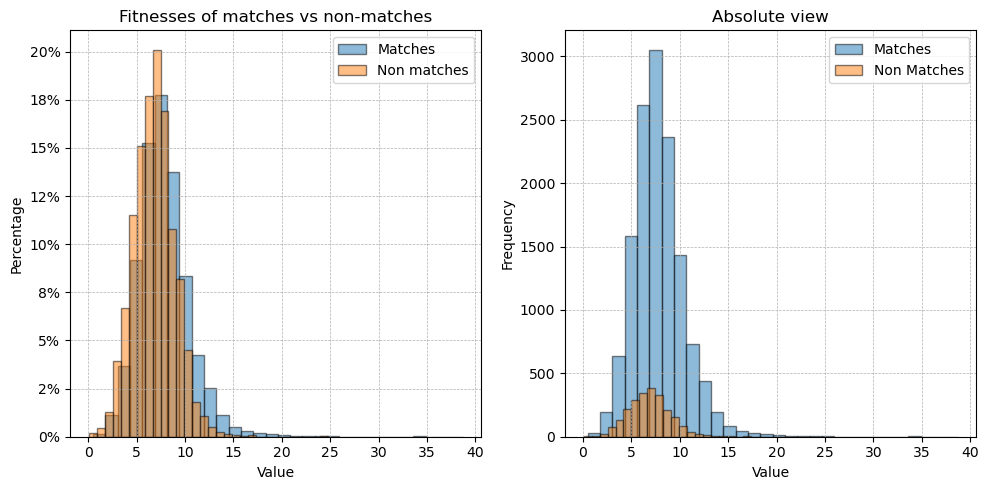

The metrics were (-31274, -0.8495643138885498)
If you match this list of 4, with threshold 1:
{188, 219, 212, 151}, gt=1
The Wasserstein distance is 0.9852369710210777
Distribution of match fitness
	n = 13503,
	average = 7.80, median = 7.56
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 2335,
	average = 6.82, median = 6.79
	min = 0.07, max = 19.70,
	


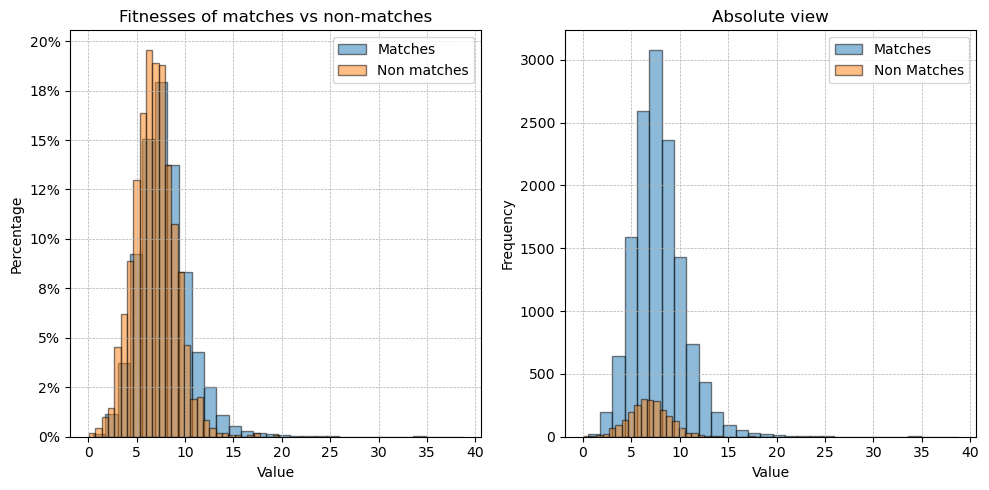

In [42]:
satisfactory_pss = best_front
for index, solution in enumerate(satisfactory_pss):
    print(index, solution.solution)

print(f"{len(satisfactory_pss)} are satisfactory out of {len(results)}")
        

for result in sorted(satisfactory_pss, key=lambda x: x.fitnesses[1]):
    print(f"The metrics were {result.fitnesses}")
    make_ps_into_explanation(result.solution, test_SPref=test_SPRef)

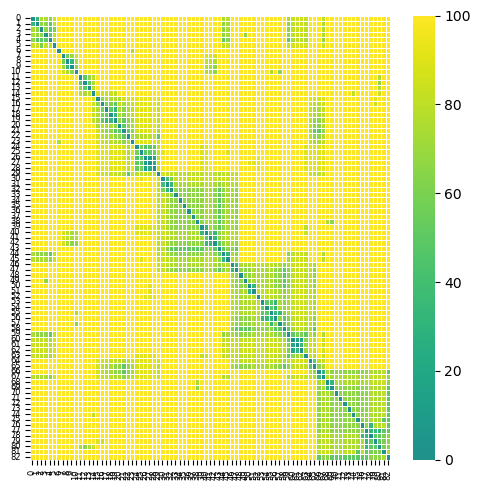

In [39]:


from initial_testing.understand_files.rearrange_linkage_table import clean_table
from collections import defaultdict



def distance_function(a: set, b: set):
    return 100 * len(set.union(a, b) - a.intersection(b)) / len(set.union(a, b))
    

to_show = satisfactory_pss
quantity = len(to_show)
distance_matrix = np.zeros(shape=(quantity, quantity), dtype=int)
for i, j in itertools.combinations(range(quantity), r=2):
    distance_matrix[i, j] = distance_function(to_show[i].solution, to_show[j].solution)


distance_matrix += distance_matrix.T

utils.show_matrix_with_colours(clean_table(distance_matrix), fig_size=(5, 5))



C:\Users\gac8\AppData\Local\Temp\ipykernel_10852\1072996255.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


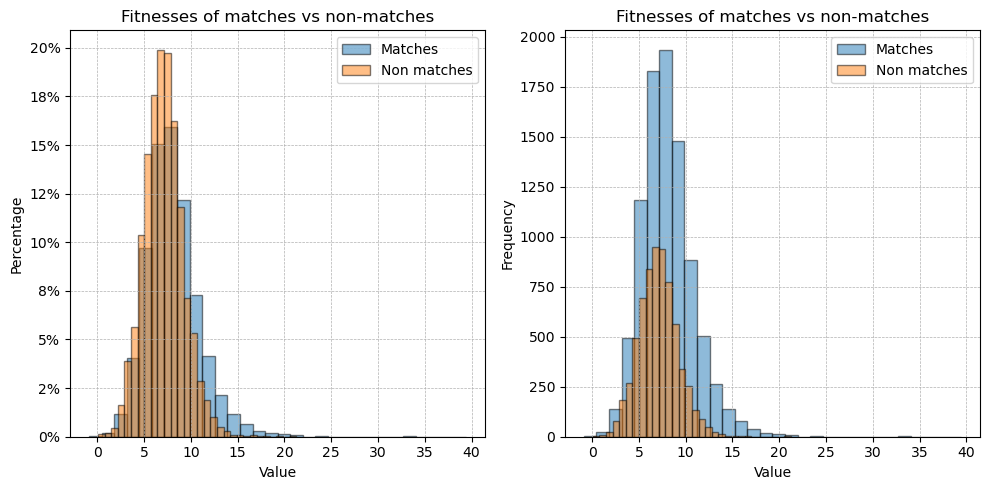

In [8]:
matches_by_any, non_matches_by_any = ([], [])


SPRef_to_get_from = test_SPRef
pss_to_consider = sorted(results, key=lambda x: x.fitnesses[2], reverse=False)[:25]
for session, fitness in zip(SPRef_to_get_from.sessions, SPRef_to_get_from.fitnesses):
    def matches_pattern(run_result):
        threshold = len(run_result.solution) if run_result.solution.genome_threshold is None else run_result.solution.genome_threshold
        return len(run_result.solution.intersection(session)) >= threshold
    if any(map(matches_pattern, pss_to_consider)):
        matches_by_any.append(fitness)
    else:
        non_matches_by_any.append(fitness)


display_side_by_side([
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "relative"
    },
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "absolute"
    },
])
            
    

In [9]:
# distribution of GT values

gt_counts = defaultdict(int)
for result in results:
    gt_counts[result.solution.genome_threshold] +=1 
    
print(gt_counts)

defaultdict(<class 'int'>, {1: 56})
